In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
cdtalbot_histopathologic_cancer_detection_path = kagglehub.dataset_download('cdtalbot/histopathologic-cancer-detection')

print('Data source import complete.')


The goal is to develop a binary image classifier to detect whether metastatic cancer tissue is present in small patches of histopathologic images.

Input:

image patches with .tif format.

Output:

Binary label:
1 → contains tumor tissue
0 → does not contain tumor tissue

Data:

train_labels.csv: CSV with image id and label (0 or 1)

train/ folder: contains .tif images

test/ folder: unlabeled images for submission

Challenge:

Small Medical images

Class imbalance is possible

Need for high AUC ROC

Exploratory Data Analysis (EDA):

Class balance: a plot shows slightly imbalanced data(more 0s than 1s)

Visualization of few images

In the code, a validation is added to be sure that all labels have images

Analysis of the model:

ResNet-18 CNN pre-trained on ImageNet is used

Last layer was replaced with nn.Linear(in_features, 1) → binary output

BCEWithLogitsLoss (binary classification loss) is used

Data pipeline:

Images resized to 32x32

Normalization applied based on ImageNet mean/std

Architecture (Resnet18):

Stage	Output Size	Layers

Conv1	16x16x64	7x7 Conv, stride=2 + MaxPool
Conv2_x	8x8x64	2 x BasicBlock(64)
Conv3_x	4x4x128	2 x BasicBlock(128)
Conv4_x	2x2x256	2 x BasicBlock(256)
Conv5_x	1x1x512	2 x BasicBlock(512)
AvgPool	1x1x512 → 512-dim vector	Global avg pool
FC	1	Linear(512→1) → BCE loss


Training procedure:

Split data into train / validation (80/20 split)

Adam optimizer is used (learning rate=1e-4)

Learning rate scheduler is used (ReduceLROnPlateau on validation AUC)

Train for 20 epochs and save the best model

Epoch 1/20 - Loss: 0.3467 - Train AUC: 0.9215 - Val AUC: 0.9528

Epoch 2/20 - Loss: 0.2745 - Train AUC: 0.9511 - Val AUC: 0.9637

Epoch 3/20 - Loss: 0.2455 - Train AUC: 0.9608 - Val AUC: 0.9698

Epoch 4/20 - Loss: 0.2230 - Train AUC: 0.9676 - Val AUC: 0.9713

Epoch 5/20 - Loss: 0.1898 - Train AUC: 0.9765 - Val AUC: 0.9755

Epoch 6/20 - Loss: 0.1726 - Train AUC: 0.9804 - Val AUC: 0.9757

Epoch 7/20 - Loss: 0.1622 - Train AUC: 0.9828 - Val AUC: 0.9766

Epoch 8/20 - Loss: 0.1381 - Train AUC: 0.9874 - Val AUC: 0.9782

Epoch 9/20 - Loss: 0.1282 - Train AUC: 0.9890 - Val AUC: 0.9776

Epoch 10/20 - Loss: 0.1202 - Train AUC: 0.9903 - Val AUC: 0.9779

Epoch 11/20 - Loss: 0.1078 - Train AUC: 0.9922 - Val AUC: 0.9789

Epoch 12/20 - Loss: 0.1011 - Train AUC: 0.9930 - Val AUC: 0.9778

Epoch 13/20 - Loss: 0.0963 - Train AUC: 0.9937 - Val AUC: 0.9769

Epoch 14/20 - Loss: 0.0896 - Train AUC: 0.9945 - Val AUC: 0.9776

Epoch 15/20 - Loss: 0.0854 - Train AUC: 0.9950 - Val AUC: 0.9776

Epoch 16/20 - Loss: 0.0820 - Train AUC: 0.9954 - Val AUC: 0.9760

Epoch 17/20 - Loss: 0.0789 - Train AUC: 0.9957 - Val AUC: 0.9758

Epoch 18/20 - Loss: 0.0774 - Train AUC: 0.9959 - Val AUC: 0.9759

Epoch 19/20 - Loss: 0.0757 - Train AUC: 0.9960 - Val AUC: 0.9760

Epoch 20/20 - Loss: 0.0732 - Train AUC: 0.9963 - Val AUC: 0.9769


Conslusion:

Good result because of Pre-trained ResNet-18

Good training pipeline with scheduler and early stopping

Possible Improvements :

Use stronger models like ResNet-34 and ResNet-50





Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64


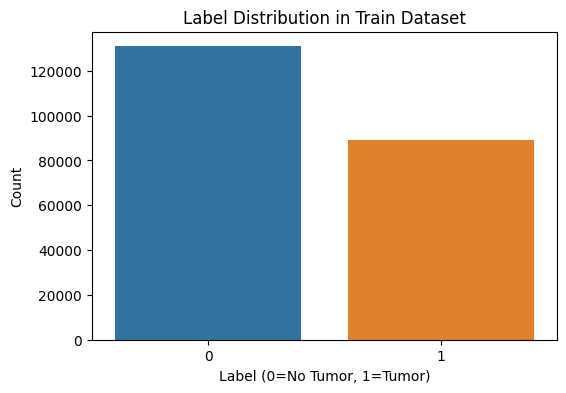

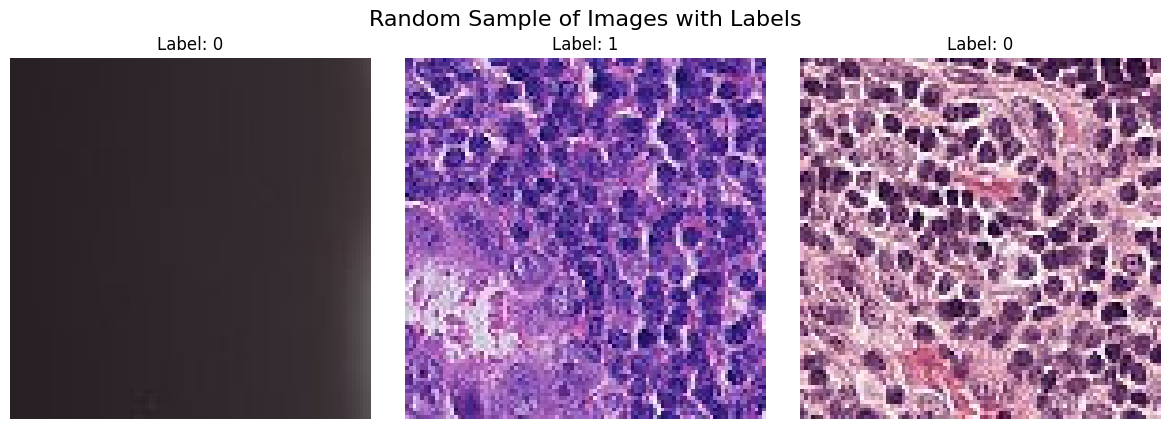

In [ ]:
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    csv_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
    img_dir = '/kaggle/input/histopathologic-cancer-detection/train'
    test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

    # Hyperparameters
    batch_size = 32
    img_size = 32
    num_epochs = 20

    # Read CSV
    data_df = pd.read_csv(csv_path)
    label_counts = data_df['label'].value_counts()

    print("Label distribution:")
    print(label_counts)

    # Plot
    plt.figure(figsize=(6,4))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title("Label Distribution in Train Dataset")
    plt.xlabel("Label (0=No Tumor, 1=Tumor)")
    plt.ylabel("Count")
    plt.show()


    # Show some random images from train set
    import random

    # Sample 9 random images from the dataframe
    sample_df = data_df.sample(3, random_state=42)

    # Plot them
    plt.figure(figsize=(12, 12))

    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(img_dir, row.id + '.tif')
        image = Image.open(img_path).convert('RGB')

        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.title(f"Label: {row.label}")
        plt.axis('off')

    plt.suptitle("Random Sample of Images with Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

Step 1: Import libraries

PIL to open .tif images

torch, nn, optim for model, loss, optimizer

Dataset, DataLoader for batching images

transforms to preprocess images (resize, normalize...)

train_test_split to split train/val

roc_auc_score to evaluate model

Step 2:

Gets id and label from CSV

Tell Pytorch how to load image/label with PIL.

Preprocess the image:

Resize to 32x32

RandomHorizontalFlip

converts image to PyTorch Tensor

Normalize using ImageNet mean/std

Returns image and label to be used for training

Step 3:

Load a ResNet18 pretrained on ImageNet

Replace the final layer (fc) with nn.Linear(..., 1) because this is a binary classification , 1 output (before sigmoid).

Step4 :

Calculate :

Loss: combines sigmoid + BCE

Optimizer : use adaptive learning rate

Scheduler : reduces LR if val_auc plateaus

Step 5:

Training loop

Forward pass

Compute loss

Backward pass

Optimizer step

train AUC

Step 6 :

Evaluate the model

Compute AUC to monitor performance

Step 7:

Save the best model

Step 8:

Test the provided test dataset.

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Define Dataset class
class PathologyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        label = torch.tensor(self.df.loc[idx, 'label'], dtype=torch.float32)
        img_path = os.path.join(self.img_dir, img_id + '.tif')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define TestDataset (no labels)
class TestDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_folder) if f.endswith('.tif')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_folder, f"{image_id}.tif")
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, image_id

# Main function
def main():
    # Paths
    csv_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
    img_dir = '/kaggle/input/histopathologic-cancer-detection/train'
    test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

    # Hyperparameters
    batch_size = 32
    img_size = 32
    num_epochs = 20

    # Read CSV
    data_df = pd.read_csv(csv_path)


    # Split train/val
    train_df, val_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)

    # Transforms
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Datasets and loaders
    train_dataset = PathologyDataset(train_df.reset_index(drop=True), img_dir, transform=transform)
    val_dataset = PathologyDataset(val_df.reset_index(drop=True), img_dir, transform=transform)
    test_dataset = TestDataset(test_dir, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    from torchvision.models import resnet18, ResNet18_Weights
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

    best_auc = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_auc = roc_auc_score(all_labels, all_preds)

        # Validation
        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_auc = roc_auc_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train AUC: {epoch_auc:.4f} - Val AUC: {val_auc:.4f}")

        scheduler.step(val_auc)

        # Save best model
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), 'best_model.pth')

    # Load best model for test
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    # Inference on test set
    predictions = []

    with torch.no_grad():
        for images, image_ids in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = (probs > 0.5).astype(int)  # Threshold at 0.5 to get 0/1

            for image_id, label in zip(image_ids, labels):
                predictions.append((image_id, label))

    # Save submission
    df_pred = pd.DataFrame(predictions, columns=['id', 'label'])
    df_pred.to_csv('submission.csv', index=False)
    print("Saved submission.csv")

# Run main
if __name__ == '__main__':
    import multiprocessing
    multiprocessing.freeze_support()
    main()

Epoch 1/20 - Loss: 0.3467 - Train AUC: 0.9215 - Val AUC: 0.9528
Epoch 2/20 - Loss: 0.2745 - Train AUC: 0.9511 - Val AUC: 0.9637
Epoch 3/20 - Loss: 0.2455 - Train AUC: 0.9608 - Val AUC: 0.9698
Epoch 4/20 - Loss: 0.2230 - Train AUC: 0.9676 - Val AUC: 0.9713
Epoch 5/20 - Loss: 0.1898 - Train AUC: 0.9765 - Val AUC: 0.9755
Epoch 6/20 - Loss: 0.1726 - Train AUC: 0.9804 - Val AUC: 0.9757
Epoch 7/20 - Loss: 0.1622 - Train AUC: 0.9828 - Val AUC: 0.9766
Epoch 8/20 - Loss: 0.1381 - Train AUC: 0.9874 - Val AUC: 0.9782
Epoch 9/20 - Loss: 0.1282 - Train AUC: 0.9890 - Val AUC: 0.9776
Epoch 10/20 - Loss: 0.1202 - Train AUC: 0.9903 - Val AUC: 0.9779
Epoch 11/20 - Loss: 0.1078 - Train AUC: 0.9922 - Val AUC: 0.9789
Epoch 12/20 - Loss: 0.1011 - Train AUC: 0.9930 - Val AUC: 0.9778
Epoch 13/20 - Loss: 0.0963 - Train AUC: 0.9937 - Val AUC: 0.9769
Epoch 14/20 - Loss: 0.0896 - Train AUC: 0.9945 - Val AUC: 0.9776
Epoch 15/20 - Loss: 0.0854 - Train AUC: 0.9950 - Val AUC: 0.9776
Epoch 16/20 - Loss: 0.0820 - Train